# Autoencoder Models Performance Analysis

## Notebook Overview 
The purpose of this notebook is to analyze the performance of various Autoencoder architectures through training and evaluation (T&E hereafter) on the CityLearn Challenge 2023 dataset.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.metrics import mean_squared_error
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderBasic as aeb
from dl_models import AutoencoderAdvanced as aea
from dl_models import AutoencoderRefined as aer
from dl_models import AutoencoderKfold as aek
from utils import plots as plt

## Introductory test
As an initial approach to the model, this T&E will be performed on the samples from Building 1 of the dataset, targeting three features:
- Cooling demand
- Carbon intensity
- Solar generation

In this case, the baseline Autoencoder is adopted, a simple architecture composed of one encoder layer and one decoder layer, each with 64 neurons and linear activation functions.
One plot for each target is generated, highlighting the NMAE, NMSE, and NRMSE, to enable comparison with the normalized performance of other models considered in the project.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
real_1, pred_1 = aeb.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size=256)

Epoch 1/1000
2/2 [==============================] - 2s 9ms/step - loss: 0.1469 - mean_absolute_error: 0.3364
Epoch 2/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.1309 - mean_absolute_error: 0.3189
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.1173 - mean_absolute_error: 0.3024
Epoch 4/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.1053 - mean_absolute_error: 0.2861
Epoch 5/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0945 - mean_absolute_error: 0.2698
Epoch 6/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0846 - mean_absolute_error: 0.2531
Epoch 7/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0757 - mean_absolute_error: 0.2364
Epoch 8/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0680 - mean_absolute_error: 0.2204
Epoch 9/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0616 - mean_absolute_error: 0.2055
Epoch 10/1000
2/2 [

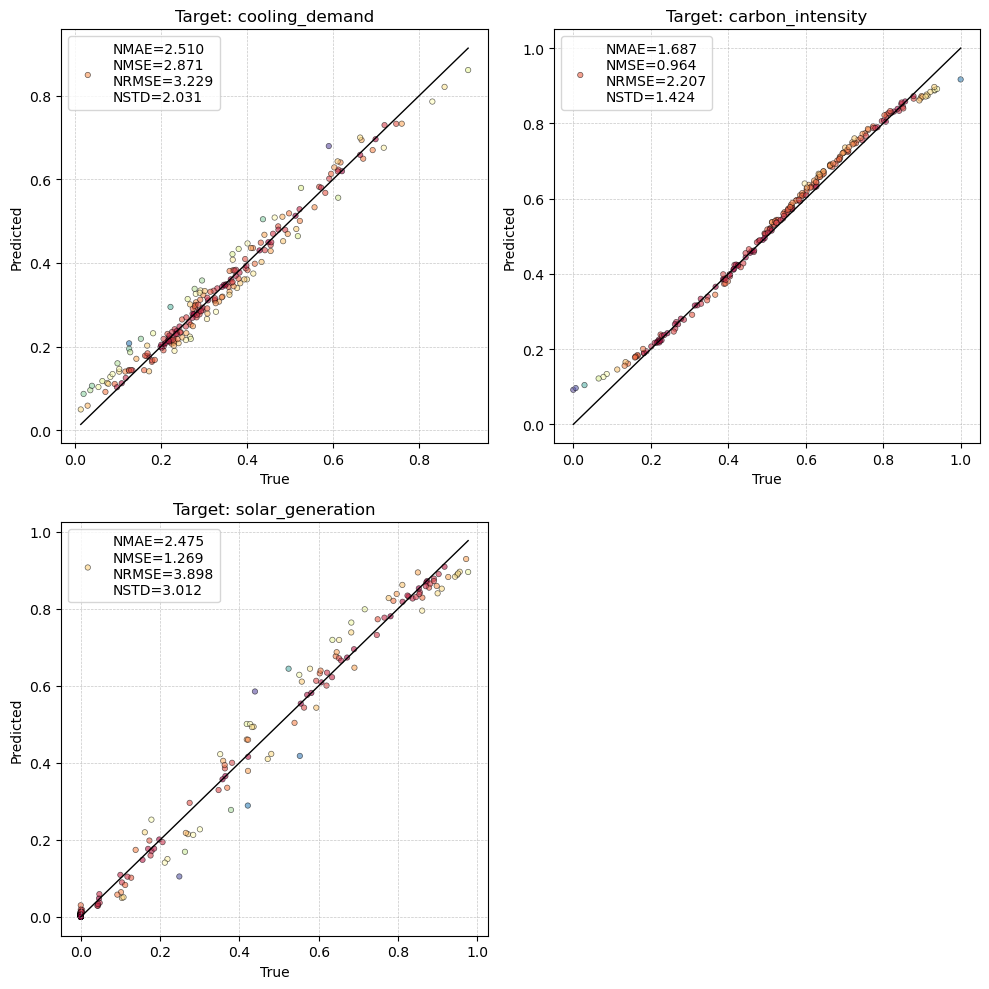

In [5]:
plt.plot_targets(real_1, pred_1, targets, features, percent=True)

## Cross-building test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [6]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [7]:
train_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [8]:
test_df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
1435,6,20,6,0,24.444447,0.000001,55.401950,0.981112,0.000000,3.581775,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
1436,6,21,6,0,24.444450,0.000005,55.363644,1.070561,0.000000,2.959194,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
1437,6,22,6,0,24.444450,0.000006,55.452953,0.816532,0.204833,2.480101,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
1438,6,23,6,0,24.444450,0.000006,55.501358,0.709542,1.768555,3.568882,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
1439,6,24,6,0,24.444440,-0.000004,55.706670,0.526549,0.000000,1.902680,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [9]:
real_2, pred_2 = aeb.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size=256)

Epoch 1/3000
3/3 [==============================] - 0s 5ms/step - loss: 0.1518 - mean_absolute_error: 0.3415
Epoch 2/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1294 - mean_absolute_error: 0.3175
Epoch 3/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.1113 - mean_absolute_error: 0.2956
Epoch 4/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0964 - mean_absolute_error: 0.2743
Epoch 5/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0834 - mean_absolute_error: 0.2526
Epoch 6/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0724 - mean_absolute_error: 0.2304
Epoch 7/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0634 - mean_absolute_error: 0.2091
Epoch 8/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0565 - mean_absolute_error: 0.1899
Epoch 9/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0514 - mean_absolute_error: 0.1753
Epoch 10/3000
3/3 [

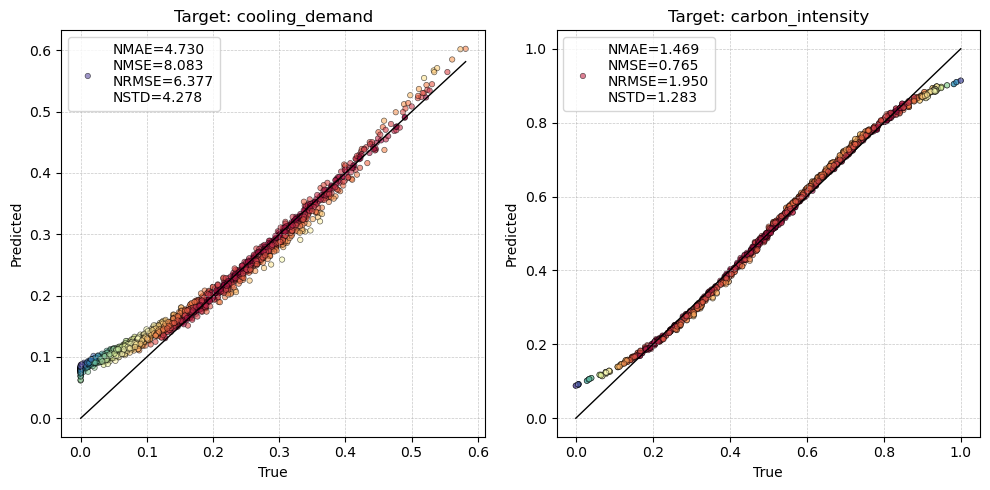

In [10]:
plt.plot_targets(real_2, pred_2, targets[:2], features, percent=True)

## Enhanced Architectures test
In this section, we evaluate the previous tests on a more advanced autoencoder architecture, designed to improve the model's ability to learn from complex data and potentially reduce errors. This architecture introduces deeper layers, different activation functions, and other optimizations aimed at enhancing performance over the previous model.

### Adding Hidden Layers

Now, two hidden layers are added to both the encoder and decoder in order to enhance the model’s representation capacity.

Encoder:
- Dense layer with 128 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 32 units and linear activation.

Bottleneck (latent) layer with n units and linear activation.

Decoder:
- Dense layer with 32 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 128 units and linear activation.

Output layer with a sigmoid activation to reconstruct the input.

This structure is designed to capture more complex relationships within the data while maintaining symmetry between the encoding and decoding paths.

In [11]:
real_3, pred_3 = aea.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size = 64)

Epoch 1/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0864 - mean_absolute_error: 0.2398
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0349 - mean_absolute_error: 0.1160
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0254 - mean_absolute_error: 0.0979
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0194 - mean_absolute_error: 0.0919
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0150 - mean_absolute_error: 0.0833
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_absolute_error: 0.0717
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_absolute_error: 0.0653
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0604
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_error: 0.0566
Epoch 10/1000
8/8 [

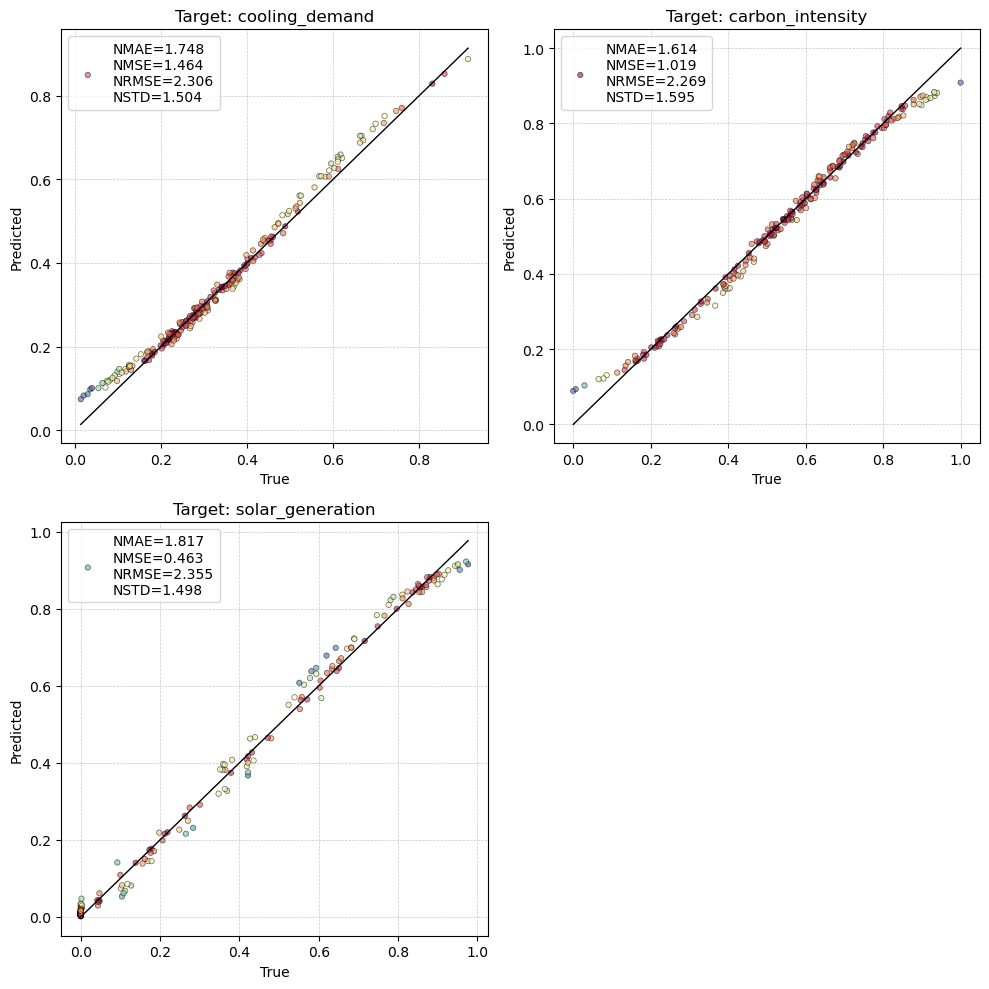

In [12]:
plt.plot_targets(real_3, pred_3, targets, features, percent=True)

In [13]:
real_4, pred_4 = aea.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size = 64)

Epoch 1/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0705 - mean_absolute_error: 0.2023
Epoch 2/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0296 - mean_absolute_error: 0.1103
Epoch 3/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.0200 - mean_absolute_error: 0.0966
Epoch 4/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0807
Epoch 5/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0685
Epoch 6/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0631
Epoch 7/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0081 - mean_absolute_error: 0.0579
Epoch 8/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0542
Epoch 9/3000
12/12 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0513
E

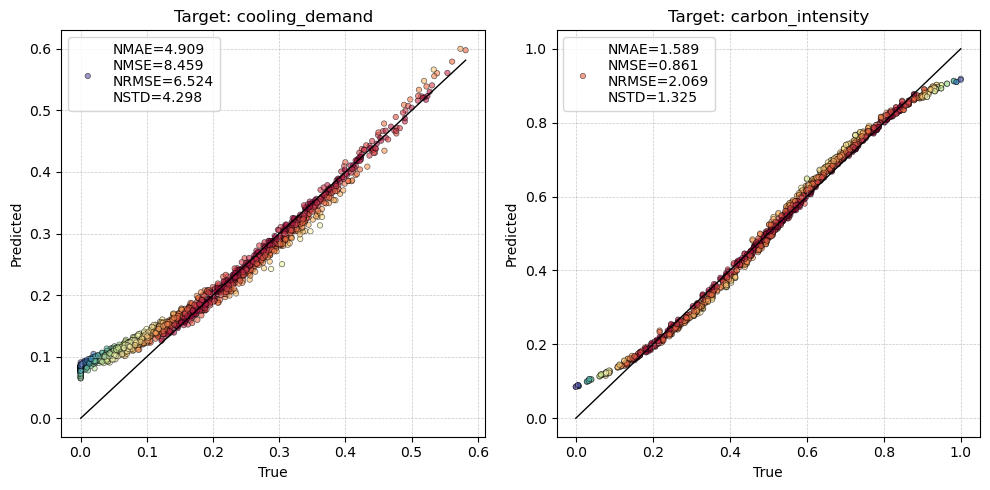

In [14]:
plt.plot_targets(real_4, pred_4, targets[:2], features, percent=True)

### Introducing Non Linear Activation Functions and Model Enhancements

To further improve the reconstruction performance, this section introduces non-linear activation functions (e.g. ReLU, ELU) within the hidden layers of the autoencoder. Additionally, the model configuration is enhanced by experimenting with a different optimizer, adjusting the dimensionality of the latent space and adding the batch normalization procedure after every layer. These changes aim to boost the model’s representation power and optimize its ability to reconstruct complex patterns in the input features.

In [15]:
real_5, pred_5 = aer.Autoencoder(dataframe=df, features=features, epochs = 1000, latent_dim = 32, batch_size = 128)

Epoch 1/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1341 - mean_absolute_error: 0.3265
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1247 - mean_absolute_error: 0.3152
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1146 - mean_absolute_error: 0.3024
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1037 - mean_absolute_error: 0.2874
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0923 - mean_absolute_error: 0.2702
Epoch 6/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0811 - mean_absolute_error: 0.2516
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0714 - mean_absolute_error: 0.2336
Epoch 8/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0633 - mean_absolute_error: 0.2165
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0573 - mean_absolute_error: 0.2012
Epoch 10/1000
4/4 [

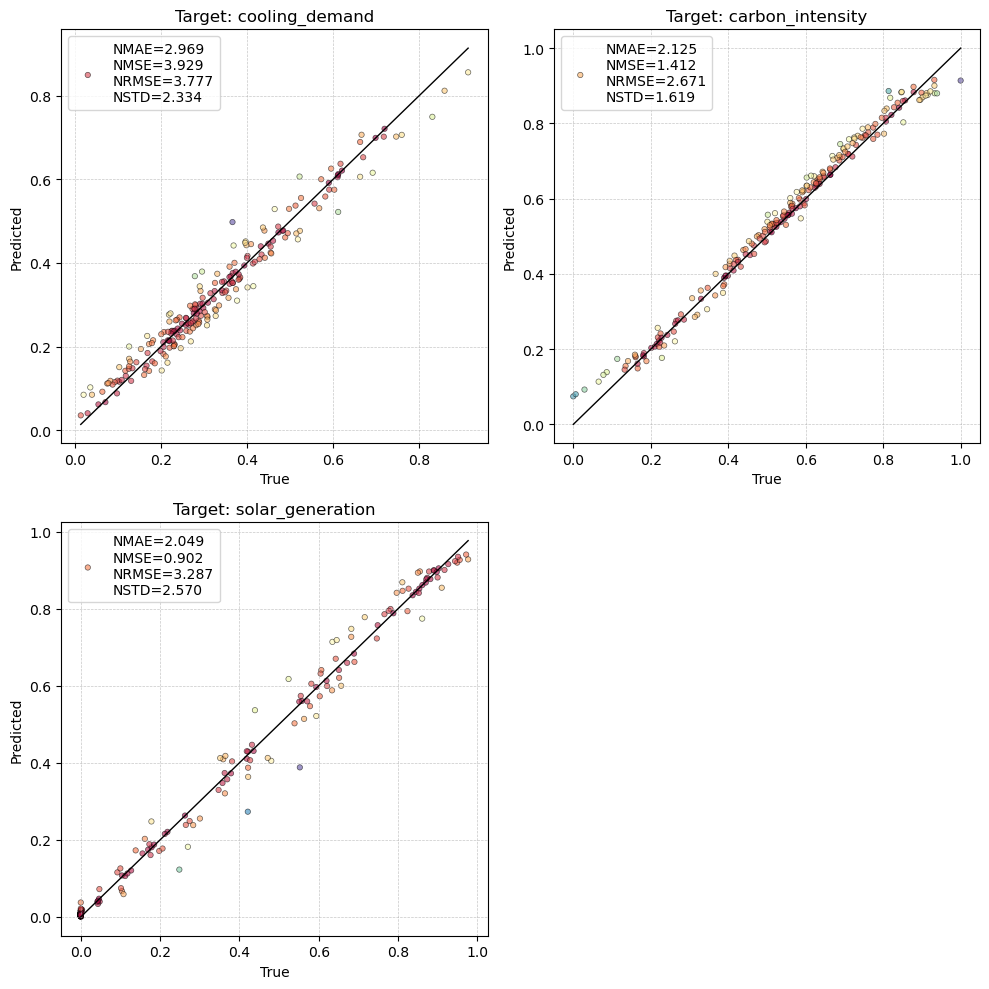

In [16]:
plt.plot_targets(real_5, pred_5, targets, features, percent=True)

In [17]:
real_6, pred_6 = aer.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)

Epoch 1/3000
6/6 [==============================] - 1s 4ms/step - loss: 0.1322 - mean_absolute_error: 0.3241
Epoch 2/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.1173 - mean_absolute_error: 0.3061
Epoch 3/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.1002 - mean_absolute_error: 0.2828
Epoch 4/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0826 - mean_absolute_error: 0.2546
Epoch 5/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0678 - mean_absolute_error: 0.2253
Epoch 6/3000
6/6 [==============================] - 0s 3ms/step - loss: 0.0585 - mean_absolute_error: 0.2010
Epoch 7/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0536 - mean_absolute_error: 0.1846
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0504 - mean_absolute_error: 0.1741
Epoch 9/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0468 - mean_absolute_error: 0.1653
Epoch 10/3000
6/6 [

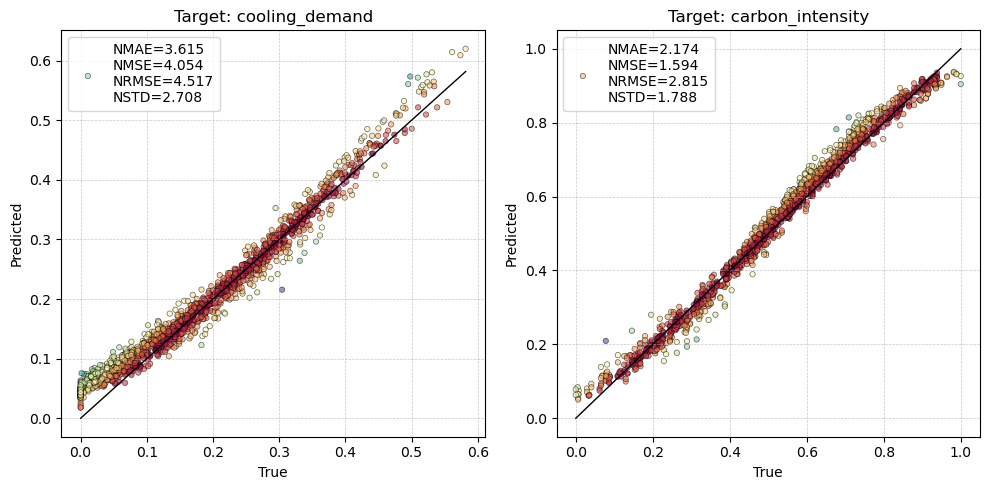

In [18]:
plt.plot_targets(real_6, pred_6, targets[:2], features, percent=True)

### Adding K-fold Cross-validation

#### Tuning
In this phase, the autoencoder is trained and evaluated using K-Fold Cross Validation, a technique that splits the dataset into k subsets (folds). Each fold is used once as a validation set while the remaining k-1 folds are used for training.
The base architecture used for the autoencoder in this phase is the same as the model described in the previous section, allowing the results to be compared effectively.

In [19]:
real_7, pred_7 = aek.Autoencoder(dataframe=df, features=features, epochs = 200, latent_dim = 64, batch_size = 32, kfold = 10)

Fold 1/10
Epoch 1/200
21/21 [==============================] - 1s 15ms/step - loss: 0.1115 - mean_absolute_error: 0.2970 - val_loss: 0.0773 - val_mean_absolute_error: 0.2432
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0616 - mean_absolute_error: 0.2076 - val_loss: 0.0565 - val_mean_absolute_error: 0.1811
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0470 - mean_absolute_error: 0.1662 - val_loss: 0.0442 - val_mean_absolute_error: 0.1558
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0353 - mean_absolute_error: 0.1423 - val_loss: 0.0347 - val_mean_absolute_error: 0.1354
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0287 - mean_absolute_error: 0.1241 - val_loss: 0.0297 - val_mean_absolute_error: 0.1199
Epoch 6/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0242 - mean_absolute_error: 0.1106 - val_loss: 0.0253 - val_mean_absolute_error: 0.1109
Epoch 7/200

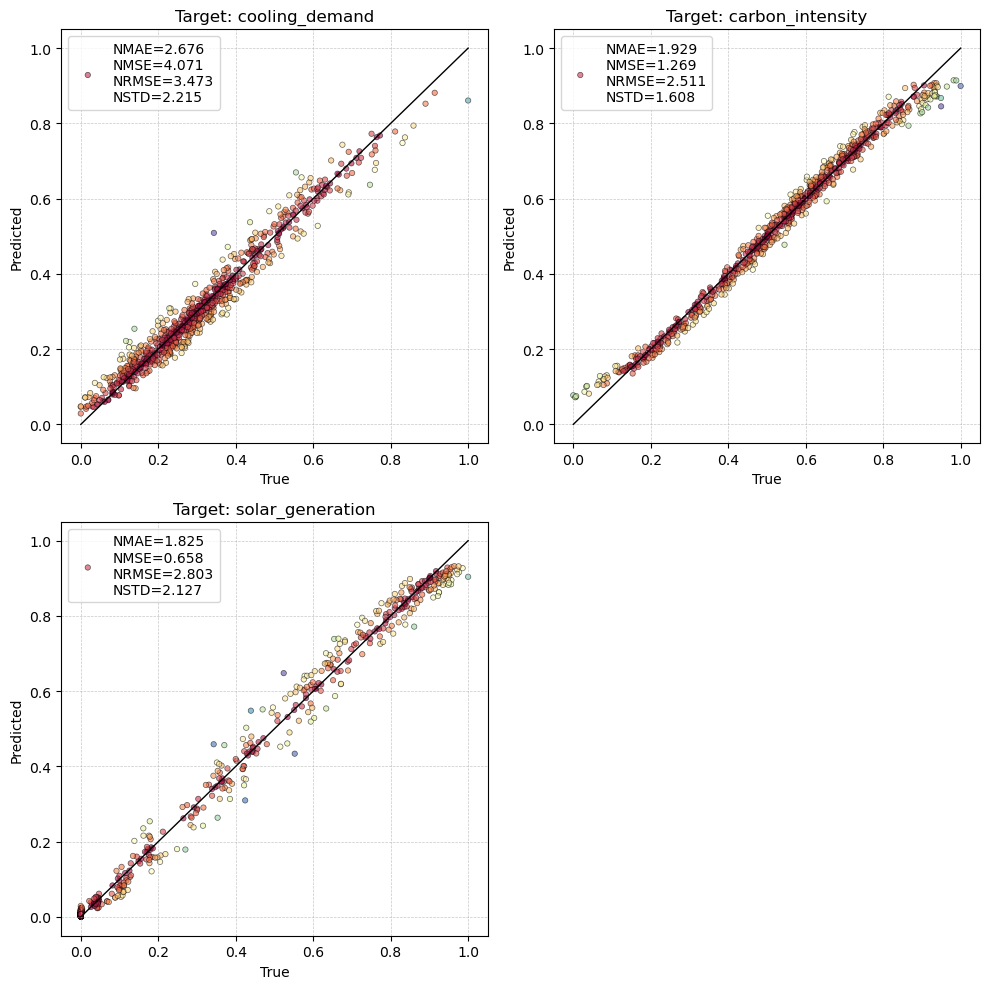

In [20]:
plt.plot_targets(real_7, pred_7, targets, features, percent=True)

#### Final Training
After choosing the best hyperparameters during the tuning phase with K-Fold Cross Validation, the model is trained on the full available dataset.
The model is trained using data from one or more buildings and then tested on a different building that was never used during training.
This method checks how well the model can generalize and perform on new, unseen data with different characteristics. It provides a more realistic and reliable evaluation for real-world situations where the model faces new buildings or environments.

In [21]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
df2 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [22]:
real_8, pred_8 = aek.Autoencoder(dataframe=df2, features=features, epochs = 1000, latent_dim = 64, batch_size = 32)

Epoch 1/1000
16/16 [==============================] - 1s 4ms/step - loss: 0.1271 - mean_absolute_error: 0.3248
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0778 - mean_absolute_error: 0.2469
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0534 - mean_absolute_error: 0.1830
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0436 - mean_absolute_error: 0.1570
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.1391
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0305 - mean_absolute_error: 0.1262
Epoch 7/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0273 - mean_absolute_error: 0.1164
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0243 - mean_absolute_error: 0.1080
Epoch 9/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0220 - mean_absolute_error: 0.1017
E

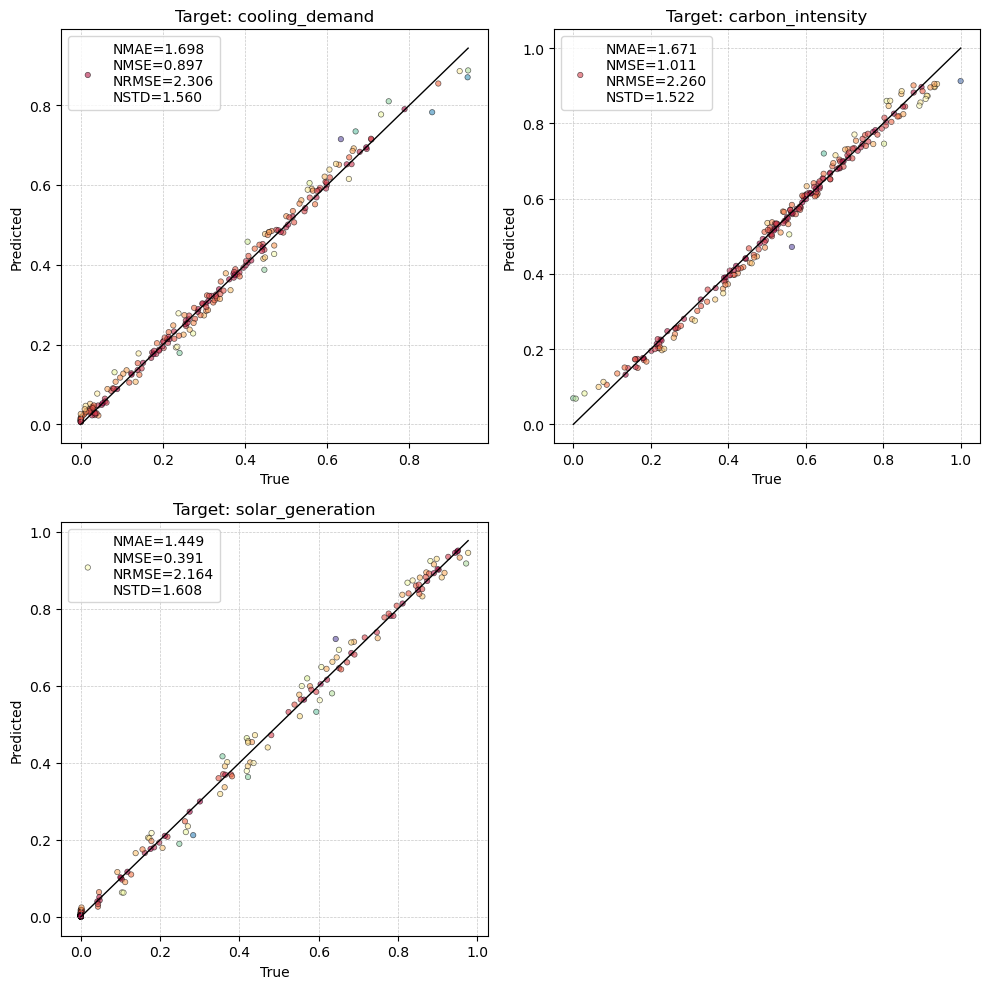

In [23]:
plt.plot_targets(real_8, pred_8, targets, features, percent=True)